# CSC8628 - Image Informatics 


## Task 1

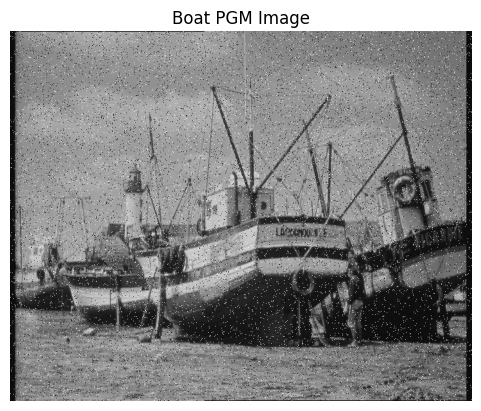

In [4]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt

# Custom imread function for PGM files
def imread_pgm(filename):
    with open(filename, 'rb') as f:
        # Read lines and handle comments
        lines = f.readlines()
        lines = [line.strip() for line in lines if not line.startswith(b'#') and line.strip()]
        
        # Check the magic number (P2 for ASCII, P5 for binary)
        header = lines[0].split()
        magic_number = header[0]
        assert magic_number in [b'P2', b'P5'], f"Unsupported PGM format: {magic_number}"
        is_ascii = magic_number == b'P2'
        
        # Extract dimensions and max pixel value
        if len(header) == 4:
            width, height, max_val = map(int, header[1:])
            data_start = 1
        else:
            width, height = map(int, lines[1].split())
            max_val = int(lines[2])
            data_start = 3
        
        if is_ascii:
            # ASCII mode
            pixel_data = ' '.join(line.decode('ascii') for line in lines[data_start:]).split()
            pixels = np.array(pixel_data, dtype=np.uint8)
        else:
            # Binary mode: skip headers explicitly
            f.seek(0)
            for _ in range(data_start):
                f.readline()
            pixel_data = f.read()
            pixels = np.frombuffer(pixel_data, dtype=np.uint8)
        
        assert pixels.size == width * height, f"Pixel data size mismatch: expected {width * height}, got {pixels.size}"
        
        return pixels.reshape((height, width))

# Display the image
def display_pgm_image(image, title='PGM Image'):
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Example usage
if __name__ == '__main__':  # Corrected variable
    image_path = "/Users/zakir/Desktop/Zakir/UNIVERSITY/Image Informatic/Dataset/noisy_4/boats.pgm"  # Replace with the different file path
    try:
        pgm_image = imread_pgm(image_path)
        display_pgm_image(pgm_image, title='Boat PGM Image')
    except Exception as e:
        print(f"Error: {e}")


## Task 2

Image successfully loaded with shape: (576, 720)
Forward wavelet transform completed.
Inverse wavelet transform completed.
Mean Squared Error (MSE) between original and reconstructed image: 0.0000


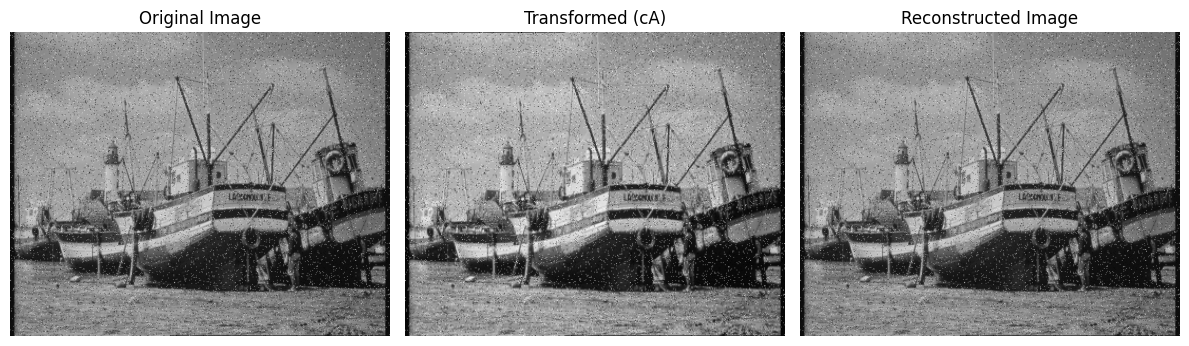

In [7]:
import pywt
import numpy as np
import matplotlib.pyplot as plt
import os

def forward_wavelet_transform(image, wavelet='haar'):
    """
    Performs a forward wavelet transform on the image.
    
    :param image: Input image as a 2D numpy array.
    :param wavelet: Wavelet type (default is 'haar').
    :return: Coefficients (cA, (cH, cV, cD)).
    """
    coeffs = pywt.dwt2(image, wavelet)
    cA, (cH, cV, cD) = coeffs
    return coeffs

def inverse_wavelet_transform(coeffs, wavelet='haar'):
    """
    Performs an inverse wavelet transform to reconstruct the image.
    
    :param coeffs: Coefficients from the forward wavelet transform.
    :param wavelet: Wavelet type (default is 'haar').
    :return: Reconstructed image as a 2D numpy array.
    """
    return pywt.idwt2(coeffs, wavelet)

def compute_mse(image1, image2):
    """
    Computes the Mean Squared Error (MSE) between two images.
    
    :param image1: Original image as a 2D numpy array.
    :param image2: Reconstructed image as a 2D numpy array.
    :return: Mean Squared Error value.
    """
    return np.mean((image1 - image2) ** 2)

def display_images(original, transformed, reconstructed):
    """
    Displays the original, transformed, and reconstructed images.
    
    :param original: Original image.
    :param transformed: Transformed coefficients as a 2D array.
    :param reconstructed: Reconstructed image.
    """
    plt.figure(figsize=(12, 6))

    # Display original image
    plt.subplot(1, 3, 1)
    plt.imshow(original, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    # Display transformed image (approximation coefficients)
    plt.subplot(1, 3, 2)
    plt.imshow(transformed, cmap='gray')
    plt.title('Transformed (cA)')
    plt.axis('off')

    # Display reconstructed image
    plt.subplot(1, 3, 3)
    plt.imshow(reconstructed, cmap='gray')
    plt.title('Reconstructed Image')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
if __name__ == '__main__':
    # Update the path to PGM file
    pgm_file_path = '/Users/zakir/Desktop/Zakir/UNIVERSITY/Image Informatic/Dataset/noisy_4/boats.pgm'
    
    try:
        # Read the PGM image
        pgm_image = imread_pgm(pgm_file_path)
        print(f"Image successfully loaded with shape: {pgm_image.shape}")
        
        # Perform forward wavelet transform
        coeffs = forward_wavelet_transform(pgm_image)
        cA, _ = coeffs  # cA is the approximation coefficients
        print("Forward wavelet transform completed.")
        
        # Perform inverse wavelet transform
        reconstructed_image = inverse_wavelet_transform(coeffs)
        print("Inverse wavelet transform completed.")
        
        # Compute MSE
        mse = compute_mse(pgm_image, reconstructed_image)
        print(f"Mean Squared Error (MSE) between original and reconstructed image: {mse:.4f}")
        
        # Display images
        display_images(pgm_image, cA, reconstructed_image)
    except Exception as e:
        print(f"Error: {e}")


## Task 3


Denoising Metrics Comparison:
                        MSE      SSIM
Wavelet        16558.421613  0.000037
Mean Filter        0.255813  0.003497
Median Filter      0.003055  0.811101
Noisy              0.015055  0.437832


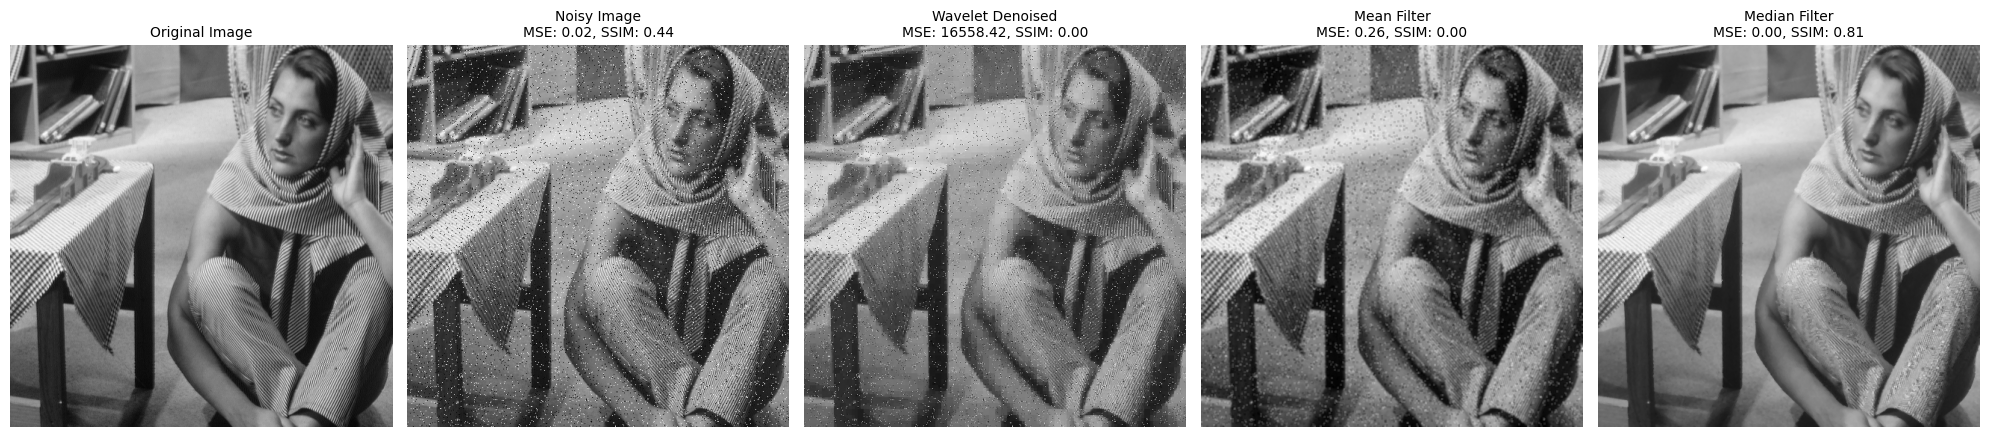

In [10]:
import numpy as np
import pywt
import cv2
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
import pandas as pd

# Preprocessing: Normalize image
def normalize_image(image):
    return image / 255.0

# Postprocessing: Clip and scale
def postprocess_image(image):
    image = np.clip(image, 0, 1)  # Ensure values are in [0, 1]
    return (image * 255).astype(np.uint8)

# Custom denoising function using Wavelet Transform
def wavelet_denoise(image, wavelet='haar', level=3, threshold_multiplier=1.0):
    """
    Perform wavelet-based denoising on an image.
    :param image: 2D numpy array (grayscale image)
    :param wavelet: Wavelet type (e.g., 'haar', 'db1')
    :param level: Decomposition level
    :param threshold_multiplier: Multiplier to adjust the threshold.
    :return: Denoised image
    """
    # Decompose the image into wavelet coefficients
    coeffs = pywt.wavedec2(image, wavelet, level=level)
    
    # Calculate adaptive threshold
    threshold = threshold_multiplier * np.sqrt(2 * np.log(image.size)) * np.median(np.abs(coeffs[-1][-1])) / 0.6745

    # Apply soft thresholding to detail coefficients
    denoised_coeffs = [coeffs[0]]  # Approximation coefficients remain unchanged
    for detail_level in coeffs[1:]:
        denoised_level = tuple(pywt.threshold(c, threshold, mode='soft') for c in detail_level)
        denoised_coeffs.append(denoised_level)
    
    # Reconstruct the denoised image
    denoised_image = pywt.waverec2(denoised_coeffs, wavelet)
    return postprocess_image(denoised_image)

# Mean filter for comparison
def mean_filter(image, kernel_size=3):
    return cv2.blur(image, (kernel_size, kernel_size))

# Median filter for comparison
def median_filter(image, kernel_size=3):
    """
    Apply median filtering to the image.
    :param image: 2D numpy array (grayscale image).
    :param kernel_size: Size of the median filter kernel (must be odd).
    :return: Median-filtered image.
    """
    # Ensure the image is in uint8 format
    image_uint8 = (image * 255).astype(np.uint8) if image.dtype != np.uint8 else image
    filtered_image = cv2.medianBlur(image_uint8, kernel_size)
    return filtered_image / 255.0  # Normalize back to [0, 1]

# Load and preprocess the image
def load_image(path, normalize=True):
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"Image at {path} not found or invalid format.")
    return normalize_image(image) if normalize else image

# Display images with improved layout and metrics
def display_images(original, noisy, denoised, mean_filtered, median_filtered, titles):
    fig, axes = plt.subplots(1, 5, figsize=(20, 5))  # One row, five columns
    images = [original, noisy, denoised, mean_filtered, median_filtered]
    
    for ax, img, title in zip(axes, images, titles):
        ax.imshow(img, cmap='gray')
        ax.set_title(title, fontsize=10)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Calculate and display metrics
def calculate_metrics(original, noisy, denoised, mean_filtered, median_filtered):
    metrics = {}
    metrics['Wavelet'] = calculate_individual_metrics(original, denoised)
    metrics['Mean Filter'] = calculate_individual_metrics(original, mean_filtered)
    metrics['Median Filter'] = calculate_individual_metrics(original, median_filtered)
    metrics['Noisy'] = calculate_individual_metrics(original, noisy)
    return metrics

# Helper function for individual metric calculation
def calculate_individual_metrics(original, denoised):
    mse_value = np.mean((original - denoised) ** 2)
    ssim_value = ssim(original, denoised, data_range=original.max() - original.min())
    return mse_value, ssim_value

# Tabular metrics report
def report_metrics(metrics):
    df = pd.DataFrame.from_dict(metrics, orient='index', columns=['MSE', 'SSIM'])
    print("\nDenoising Metrics Comparison:")
    print(df)

# Main function for task execution
if __name__ == '__main__':
    # input the paths with the actual file paths
    original_image_path = "/Users/zakir/Desktop/Zakir/UNIVERSITY/Image Informatic/Dataset/original/barbara.pgm"
    noisy_image_path = "/Users/zakir/Desktop/Zakir/UNIVERSITY/Image Informatic/Dataset/noisy_4/barbara.pgm"

    # Load and preprocess images
    original_image = load_image(original_image_path)
    noisy_image = load_image(noisy_image_path)

    # Apply denoising methods
    wavelet_denoised = wavelet_denoise(noisy_image, wavelet='db1', level=3, threshold_multiplier=1.0)
    mean_filtered = normalize_image(mean_filter(noisy_image))
    median_filtered = median_filter(noisy_image)

    # Calculate metrics
    metrics = calculate_metrics(original_image, noisy_image, wavelet_denoised, mean_filtered, median_filtered)
    report_metrics(metrics)

    # Display results
    titles = [
        "Original Image",
        f"Noisy Image\nMSE: {metrics['Noisy'][0]:.2f}, SSIM: {metrics['Noisy'][1]:.2f}",
        f"Wavelet Denoised\nMSE: {metrics['Wavelet'][0]:.2f}, SSIM: {metrics['Wavelet'][1]:.2f}",
        f"Mean Filter\nMSE: {metrics['Mean Filter'][0]:.2f}, SSIM: {metrics['Mean Filter'][1]:.2f}",
        f"Median Filter\nMSE: {metrics['Median Filter'][0]:.2f}, SSIM: {metrics['Median Filter'][1]:.2f}",
    ]
    display_images(original_image, noisy_image, wavelet_denoised, mean_filtered, median_filtered, titles)
